# Data and Study Design

In our experiment we had two cohorts of mice. **Mice 2-5** received a fecal transplant from a **Healthy** human donor. **Mice 6-10** received am FMT from a human donor with **Ulcerative Colitis (UC)**. We refere to these mouse cohorts as the Healthy and UC cohorts.  

An overview of the experiment is provided in the following figure
![](figure/study_design.png)

In this notebook we will explore the two sources of data: qPCR for total bacterial load and reads from Amplicon sequencing. We will also go over the timing of fecal sample collection and perturbations as well as provide taxonomies for the associated amplicon sequences that were identified in the samples.

---

In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

from sklearn.metrics.pairwise import manhattan_distances
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix

import seaborn as sns
lines_to_show=12

# !pip install biopython

In [2]:
# Custom extra width cells
from IPython.core.display import HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


## Metadata

The following table is a metadata table.  For every sampleID it has the corresponding subject (mouse) and timepoint (in days) of fecal sample collection. The fractional part of the time numbers, .0 or 0.5, represent AM and PM.

In [3]:
metadata = pd.read_csv('data/metadata.tsv', sep='\t')
metadata.head(lines_to_show)

,sampleID,subject,time
0,10-D0AM,10,0.0
1,10-D10,10,10.0
2,10-D11,10,11.0
3,10-D14,10,14.0
4,10-D16,10,16.0
5,10-D18,10,18.0
6,10-D1AM,10,1.0
7,10-D1PM,10,1.5
8,10-D21AM,10,21.0
9,10-D21PM,10,21.5


## qPCR


The following table is a qPCR table. This has the replicate measurements (3) of the qPCR for every sample (already normalized by the mass of the fecal pellet) in the units of CFU/g.

CFU/g: Colony Forming Units per gram of feces

In [4]:
qpcr = pd.read_csv('data/qpcr.tsv', sep='\t')
qpcr.head(lines_to_show)

,sampleID,measurement1,measurement2,measurement3
0,10-D0AM,3.124446e+07,6.624073e+07,2.146892e+07
1,10-D10,1.249714e+11,1.476571e+11,5.866129e+10
2,10-D11,1.430439e+11,2.154554e+11,2.931997e+11
3,10-D14,7.274684e+10,1.950943e+11,6.949483e+10
4,10-D16,9.364484e+10,1.167788e+11,1.107184e+11
5,10-D18,5.760466e+10,7.984920e+10,1.032151e+11
6,10-D1AM,8.787440e+09,1.503446e+10,1.081238e+10
7,10-D1PM,4.975814e+10,1.093237e+11,1.121214e+11
8,10-D21AM,1.305030e+11,2.303749e+11,1.680958e+11
9,10-D21PM,1.879675e+11,1.953849e+11,3.029993e+11


# Sequencing counts
 - rows: ASVs
 - columns: samples (mouse_ID - day)

The following table is a read counts table. This shows the number of reads associated with each ASV for each sample ID.

Counts
For the experiment in that column
ASV_1 it that specific sequence has been counted 22 times at that timeframe for that mouse
And so if we had a larger part of samples, then the counts would be way higher. That's why we want to normalize (or something else), so divide by the max count that was observed for a mouse on a timeframe 

In [5]:
counts = pd.read_csv('data/counts.tsv', sep='\t')
counts

,Unnamed: 0,10-D0AM,10-D10,10-D11,10-D14,10-D16,10-D18,10-D1AM,10-D1PM,10-D21AM,...,9-D60AM,9-D60PM,9-D61,9-D62,9-D63,9-D64AM,9-D64PM,9-D7,9-D8,9-D9
0,ASV_1,22,10503,21726,25990,21572,21352,17823,16916,26669,...,23613,20729,37601,38306,21944,12971,24560,12622,10323,10960
1,ASV_2,21,9319,17515,20188,14972,14868,6627,7697,20212,...,10875,11709,6582,7369,4935,7152,15477,7814,9361,8009
2,ASV_3,3,9380,17748,20899,15247,17260,45,1078,21997,...,21,6,120,21,502,1034,5944,19830,15778,22068
3,ASV_4,0,0,7,24,5,20,0,0,0,...,22,19,25,23,24,20,45,8,0,0
4,ASV_5,0,0,0,0,0,0,0,0,0,...,15,20,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,ASV_1469,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1469,ASV_1470,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1470,ASV_1471,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1471,ASV_1472,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
counts.iloc[:,1:] += (counts.iloc[:,1:]==0)*0.001
counts

,Unnamed: 0,10-D0AM,10-D10,10-D11,10-D14,10-D16,10-D18,10-D1AM,10-D1PM,10-D21AM,...,9-D60AM,9-D60PM,9-D61,9-D62,9-D63,9-D64AM,9-D64PM,9-D7,9-D8,9-D9
0,ASV_1,22.000,10503.000,21726.000,25990.000,21572.000,21352.000,17823.000,16916.000,26669.000,...,23613.000,20729.000,37601.000,38306.000,21944.000,12971.000,24560.000,12622.000,10323.000,10960.000
1,ASV_2,21.000,9319.000,17515.000,20188.000,14972.000,14868.000,6627.000,7697.000,20212.000,...,10875.000,11709.000,6582.000,7369.000,4935.000,7152.000,15477.000,7814.000,9361.000,8009.000
2,ASV_3,3.000,9380.000,17748.000,20899.000,15247.000,17260.000,45.000,1078.000,21997.000,...,21.000,6.000,120.000,21.000,502.000,1034.000,5944.000,19830.000,15778.000,22068.000
3,ASV_4,0.001,0.001,7.000,24.000,5.000,20.000,0.001,0.001,0.001,...,22.000,19.000,25.000,23.000,24.000,20.000,45.000,8.000,0.001,0.001
4,ASV_5,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,15.000,20.000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1468,ASV_1469,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1469,ASV_1470,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1470,ASV_1471,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
1471,ASV_1472,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


## Relative Counts & Absolute ASV Concentrations
 -  **Relative Counts** (`rel_counts`) : 
 $$\textrm{Rel. Counts}_{\textrm{(ASV i, sample j)}} =
 \frac{\textrm{Counts}_{\textrm{(ASV i, sample j)}}}{\textrm{Read Depth}_{\textrm{(sample j)}}}$$
 $$\textrm{Read Depth}_{\textrm{(sample j)}} = \sum_{i} \textrm{Counts}_{\textrm{(ASV i, sample j)}}$$
 -  **Absolute ASV Concentration** (`concentrations`): 
  $$\textrm{Abs. Conc.}_{\textrm{(ASV i, sample j)}} = \textrm{Total Bacteria Conc.}_{\textrm{(sample j)}} \times
 \textrm{Rel. Counts}_{\textrm{(ASV i, sample j)}}$$
 $$\textrm{Total Bacteria Conc.}_{\textrm{(sample j)}} = \frac{1}{3}\sum_{m=1}^3\textrm{Total Bacteria Conc.}_{\textrm{(sample j, measurement m)}} $$

Aboslute ASV Contration: 
Read depth: Everything summed in 1 column, so all the counts for all the sequences at 1 timepoint measured for 1 mouse


In [7]:
rel_counts = counts.copy()
concentrations = counts.copy()
for sample_id in counts.columns[1:]:
    rel_counts[sample_id] = counts[sample_id] / counts[sample_id].sum(axis=0)
    
    total_bacteria = qpcr[qpcr['sampleID']==sample_id].mean(axis=1).values[0]
    concentrations[sample_id] = total_bacteria * rel_counts[sample_id]

Confirm that each column in `concentrations` sums up to the average qPCR concentration

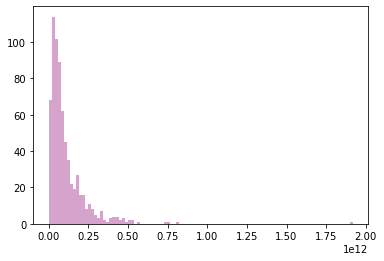

In [8]:
plt.hist(concentrations.iloc[:,1:].sum(axis=0), color='b', alpha = 0.2, bins=100)
plt.hist(qpcr.mean(axis=1), color='r', alpha = 0.2, bins=100)
plt.show()

Recall that read counts are not quantitative (but are instead relative to the read depth). The total read depth for each sample can be computed as

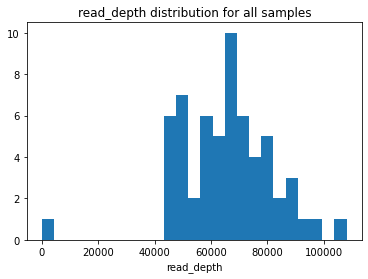

In [9]:
read_depth=counts.sum()[1:] # first column was just the ASV number hence indexing from 1 to the end, removing the 0 index
plt.hist(read_depth.head(60), bins=25)
plt.title("read_depth distribution for all samples")
plt.xlabel("read_depth")
plt.show()

The read depth for each sample changes, but the read depth does not correspond to changes in total bacterial load. That is why we also have a qPCR measurement for estimating total bacterial load in each sample.

## ASV number, sequences and taxonomy

The taxonomy table relates the ASV number to the actual amplicon sequence associated with the ASV number. In addition you have the taxonomic information down to the species level (if the classification is known). When multiple species are provided it means that those species all have the same ASV (and this specific region of the 16S rRNA gene is not enough to destinguish them) and if `NaN` then that ASV did not have an associated species in the training set or more than 5 species were returned.

In [10]:
asv_and_taxonomy = pd.read_csv('data/asv_and_taxonomy.tsv', sep='\t')
asv_and_taxonomy

,name,sequence,Kingdom,Phylum,Class,Order,Family,Genus,Species
0,ASV_1,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Phocaeicola,NaN
1,ASV_2,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,fragilis/ovatus
2,ASV_3,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
3,ASV_4,TACGGAGGATCCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGAG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Bacteroidaceae,Bacteroides,cellulosilyticus/intestinalis/timonensis
4,ASV_5,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,muciniphila
...,...,...,...,...,...,...,...,...,...
1468,ASV_1469,TACGTAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGGGTG...,Bacteria,Bacteroidetes,Bacteroidia,Bacteroidales,Porphyromonadaceae,Parabacteroides,NaN
1469,ASV_1470,TACGTAGGGGGCAAGCGTTATCCGGAATCATTGGGCGTAAAGGGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,NaN
1470,ASV_1471,TACGTAGGGGGCAAGCGTTATCCGGAATCATTGGGCGTAAAGGGTG...,Bacteria,Verrucomicrobia,Verrucomicrobiae,Verrucomicrobiales,Akkermansiaceae,Akkermansia,NaN
1471,ASV_1472,TACAGAGGGTGCGAGCGTTAATCGGATTTACTGGGCGTAAAGCGTG...,Bacteria,Proteobacteria,Betaproteobacteria,Burkholderiales,Sutterellaceae,Parasutterella,NaN


In [11]:
seq_count = asv_and_taxonomy['sequence'].nunique()
spec_count = asv_and_taxonomy['Species'].nunique()

print(f"We have {seq_count} annd {spec_count} derived or composed (spec1/spec2 etc) from them")

We have 1473 annd 133 derived or composed (spec1/spec2 etc) from them


In [12]:
# Custom function to get nan stats for empty rows
def nan_row_stats(df_missing):
    # Get the rows with all null values
    idx = df_missing.index[df_missing.isnull().all(1)]
    nans = df_missing.iloc[idx]
    if len(nans) > 1:
        print("Dataframe has rows with each column value being empty")
        display(nans)
    else:
        print(f"Dataframe with {len(df_missing)} rows, does not have rows with all empty values")
        
# Custom function to get nan stats for values
def nan_vals_stats(df_missing, show_summary=False, show_rows=False):
    # Get the missing values per each column 
    missing_series = df_missing.isna().sum()

    # Concatunate each column's type so we have a better idea for imputation
    missing_types_df = pd.concat([missing_series.rename('Missing'), df_missing.dtypes.rename('Dtype')], axis=1)
    missing_types_df.sort_values(by=['Missing'], ascending=False, inplace=True)
    display(missing_types_df)
    
    # Get the column names where values are missing
    missing_colnames = missing_types_df[missing_types_df['Missing']>0].index.tolist()
    
    if len(missing_colnames) > 0:
        # Output missing column's stats for imputaiton 
        if show_summary:
            # Get the basic information of our missing columns
            display(df_missing[missing_colnames].describe())

        # Also output missing rows, needed to determine adequate imputation method
        if show_rows:
            null_data_df = df_missing[df_missing.isnull().any(axis=1)]
            display(null_data_df)

In [13]:
# Check for nan values
nan_row_stats(asv_and_taxonomy)
nan_vals_stats(asv_and_taxonomy)

Dataframe with 1473 rows, does not have rows with all empty values


,Missing,Dtype
Species,1316,object
Genus,401,object
Family,119,object
Order,61,object
Class,55,object
Phylum,32,object
name,0,object
sequence,0,object
Kingdom,0,object


### 1316 ASVs don't have all the taxonomy information (some fields are NaNs):

In [14]:
#rows containing a NaN value in at lest one of the Taxonomy columns
nan_rows = asv_and_taxonomy[asv_and_taxonomy.isna().any(axis=1)]

#n_nans = Number of Taxonomy levels/columns with a NaN, for each row
nan_rows["n_nans"] = nan_rows.isna().sum(axis=1)

#Number of ASVs (rows) that have the same number of NaNs
print("n NaNs  | # ASVs with n NaNs in taxonomy\n"+"-"*40)
for n_nans, rows in nan_rows["n_nans"].value_counts().sort_index().items():
    print(f"   {n_nans}    |        {rows}")
print("-"*40+"\n\t|  sum: ", nan_rows["n_nans"].value_counts().sum())

n NaNs  | # ASVs with n NaNs in taxonomy
----------------------------------------
   1    |        915
   2    |        282
   3    |        58
   4    |        6
   5    |        23
   6    |        32
----------------------------------------
	|  sum:  1316


C:\Users\svazq\Anaconda3\envs\cs109b\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [15]:
ASVs_with_n_nans = {n_nans: [] for n_nans in range(1,7)}
for name, n_nans in zip(nan_rows["name"],nan_rows["n_nans"]):
    ASVs_with_n_nans[n_nans].append(name)
    
rows_with_n_nans = {n_nans: [] for n_nans in range(1,7)}
for name, n_nans in zip(nan_rows["name"],nan_rows["n_nans"]):
    row = int(np.where(asv_and_taxonomy["name"] == name)[0])
    rows_with_n_nans[n_nans].append(row)
    
display(ASVs_with_n_nans[4])
display(rows_with_n_nans[4])

['ASV_315', 'ASV_332', 'ASV_1090', 'ASV_1170', 'ASV_1191', 'ASV_1363']

[314, 331, 1089, 1169, 1190, 1362]

# Filter Out unsignificant ASVs
ASVs in which:
1. ALL mice (or all except 1) have counts=0 for all time points (or all except 1 or 2).    
   **AND** :
     - a. for ALL mice, there is <1 count/sample(time point) on average.    
       **OR**
     - b. for ALL mice, the maximum counts are <10.
     
A second, alternative is to substitute point 1 by:   

2. ALL mice have 0 counts in >95% of the time points measured for that mouse    

In [16]:
# rows_to_remove
counts_ = counts.copy()
counts_.index = counts_['Unnamed: 0']
counts_ = counts_.drop(columns='Unnamed: 0')

In [17]:
dates = {"HFD":[21.5, 28.5], "V":[35.5, 42.5], "G": [50.5, 57.5]}

n_0_countss = []
maxlims = []
avgs = []

rows_to_remove = []

for r in range(counts.shape[0]):
    # len(x)-2 -> How many mice have all counts 0 for that ASV, with the exception of 1 or 2
    n_0_counts = counts_.iloc[r].groupby(level=0).apply(lambda x: sum(x==0.001)>=(len(x)-1)).sum()  #alternative 1
    #n_0_counts = counts_.iloc[r].groupby(level=0).apply(lambda x: sum(x==0.001)/len(x))   #alternative 2
    maxlim = counts_.iloc[r].groupby(level=0).max()
    avg = counts_.iloc[r].groupby(level=0).mean()
    
    if (n_0_counts>=8) & ( ((avg<1).all()) | ((maxlim <10).all()) ):   #alternative 1
    #if ((n_0_counts>0.95)==True).all() & ((avg<1).all() | (maxlim <10).all()):   #alternative 2
        #print(r)
        n_0_countss.append(n_0_counts) #only useful for alternative 2
        maxlims.append(maxlim)
        avgs.append(avg)
        rows_to_remove.append(r)
        
        plot= 0
        if plot:
            max_maxlim = max(maxlim)
            counts_.iloc[r].groupby(level=0).plot()
            plt.fill_between(dates["HFD"],max_maxlim,color="b",alpha=0.3)
            plt.fill_between(dates["V"],max_maxlim,color="r",alpha=0.3)
            plt.fill_between(dates["G"],max_maxlim,color="g",alpha=0.3)
            plt.xticks([]); plt.legend(); plt.show()

With our filters, we can **exclude 1018 ASVs** out of the 1473 that we initially had, **leaving 455** ASVs:

In [18]:
counts_.shape[0], len(rows_to_remove), counts_.shape[0]-len(rows_to_remove)

(1473, 985, 488)

### Confirm that we eliminated just "potential garbage"

In [24]:
# counts_per_mouse_and_day = counts_.sum(axis=0).unstack(level=0)
# counts_removed_per_mouse_and_day = counts_.iloc[rows_to_remove].sum(axis=0).unstack(level=0)

# plt.figure(figsize=(12,5))
# ax1=plt.subplot(121); counts_per_mouse_and_day.plot(ax=ax1)
# plt.ylabel("Total number of counts"); plt.title("Total number of counts")

# ax2=plt.subplot(122); counts_removed_per_mouse_and_day.plot(ax=ax2)
# plt.ylabel("Number of counts removed"); plt.title("Number of counts removed")
# plt.show()

In the following plot we can see that, **for each time point**, by removing those 1018 ASVs, **we are only removing around 0.01% of the total counts**. 

The only exception is at the very beginning of the experiment, which we can ignore because we are not interested in those initial settlement dynamics and, the first days have very low total counts (probably meaning that bacteria have still not colonized the mice's gut).

In [26]:
# percentage = 100*counts_removed_per_mouse_and_day/counts_per_mouse_and_day

# percentage.plot(figsize=(8,5))
# percentage.mean(axis=1).plot(c='k', linewidth=3, label="average for 9 mice")
# plt.axhline(0.01, ls='--', c='k', label="0.01 % reference")
# plt.yscale('log')
# plt.ylabel("% of counts removed (log scale)")
# plt.legend()
# plt.show()

# log-transformation

In [28]:
# concentrations_r_sc = concentrations_r.copy()

In [29]:
# concentrations_r_log = concentrations_r.copy()
# concentrations_r_log.iloc[:,:] = np.log10(concentrations_r.values)

In [30]:
# concentrations_r_sc_log = concentrations_r_sc.copy()
# concentrations_r_sc_log.iloc[:,:] = np.log10(concentrations_r_sc.values)

In [31]:
# plt.figure(figsize=(12,8))
# plt.hist(concentrations_r_log.values)
# plt.legend()
# plt.show()

# Vasco's multi index

# MultiIndex for easier data manipulation


### IMPORTANT NOTES:
- I am using normal counts, so I havent tried this with the actual log transformation from above
- Perhaps you do want to keep the other predictors like 'family' as index so you can use that to color the dimensional plots. Or alternatively you can keep a seperate list of them and then use that for coloring later on

First, create Dataframes (ending with `_`) with first row as the index:

In [19]:
counts.head()

,Unnamed: 0,10-D0AM,10-D10,10-D11,10-D14,10-D16,10-D18,10-D1AM,10-D1PM,10-D21AM,...,9-D60AM,9-D60PM,9-D61,9-D62,9-D63,9-D64AM,9-D64PM,9-D7,9-D8,9-D9
0,ASV_1,22.000,10503.000,21726.000,25990.000,21572.000,21352.000,17823.000,16916.000,26669.000,...,23613.0,20729.0,37601.000,38306.000,21944.000,12971.000,24560.000,12622.000,10323.000,10960.000
1,ASV_2,21.000,9319.000,17515.000,20188.000,14972.000,14868.000,6627.000,7697.000,20212.000,...,10875.0,11709.0,6582.000,7369.000,4935.000,7152.000,15477.000,7814.000,9361.000,8009.000
2,ASV_3,3.000,9380.000,17748.000,20899.000,15247.000,17260.000,45.000,1078.000,21997.000,...,21.0,6.0,120.000,21.000,502.000,1034.000,5944.000,19830.000,15778.000,22068.000
3,ASV_4,0.001,0.001,7.000,24.000,5.000,20.000,0.001,0.001,0.001,...,22.0,19.0,25.000,23.000,24.000,20.000,45.000,8.000,0.001,0.001
4,ASV_5,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,15.0,20.0,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [20]:
asv_raw1_df = counts.copy()

# Rename ASV column
asv_raw1_df = asv_raw1_df.rename(columns = {'Unnamed: 0': 'ASV'}, inplace = False)
asv_raw1_df.head()

,ASV,10-D0AM,10-D10,10-D11,10-D14,10-D16,10-D18,10-D1AM,10-D1PM,10-D21AM,...,9-D60AM,9-D60PM,9-D61,9-D62,9-D63,9-D64AM,9-D64PM,9-D7,9-D8,9-D9
0,ASV_1,22.000,10503.000,21726.000,25990.000,21572.000,21352.000,17823.000,16916.000,26669.000,...,23613.0,20729.0,37601.000,38306.000,21944.000,12971.000,24560.000,12622.000,10323.000,10960.000
1,ASV_2,21.000,9319.000,17515.000,20188.000,14972.000,14868.000,6627.000,7697.000,20212.000,...,10875.0,11709.0,6582.000,7369.000,4935.000,7152.000,15477.000,7814.000,9361.000,8009.000
2,ASV_3,3.000,9380.000,17748.000,20899.000,15247.000,17260.000,45.000,1078.000,21997.000,...,21.0,6.0,120.000,21.000,502.000,1034.000,5944.000,19830.000,15778.000,22068.000
3,ASV_4,0.001,0.001,7.000,24.000,5.000,20.000,0.001,0.001,0.001,...,22.0,19.0,25.000,23.000,24.000,20.000,45.000,8.000,0.001,0.001
4,ASV_5,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,15.0,20.0,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [21]:
# Filter out ASV's we don't need
asv_raw2_df = asv_raw1_df.drop(asv_raw1_df.index[rows_to_remove])
# print(rows_to_remove)
asv_raw2_df

,ASV,10-D0AM,10-D10,10-D11,10-D14,10-D16,10-D18,10-D1AM,10-D1PM,10-D21AM,...,9-D60AM,9-D60PM,9-D61,9-D62,9-D63,9-D64AM,9-D64PM,9-D7,9-D8,9-D9
0,ASV_1,22.000,10503.000,21726.000,25990.000,21572.000,21352.000,17823.000,16916.000,26669.000,...,23613.000,20729.000,37601.000,38306.000,21944.000,12971.000,24560.000,12622.000,10323.000,10960.000
1,ASV_2,21.000,9319.000,17515.000,20188.000,14972.000,14868.000,6627.000,7697.000,20212.000,...,10875.000,11709.000,6582.000,7369.000,4935.000,7152.000,15477.000,7814.000,9361.000,8009.000
2,ASV_3,3.000,9380.000,17748.000,20899.000,15247.000,17260.000,45.000,1078.000,21997.000,...,21.000,6.000,120.000,21.000,502.000,1034.000,5944.000,19830.000,15778.000,22068.000
3,ASV_4,0.001,0.001,7.000,24.000,5.000,20.000,0.001,0.001,0.001,...,22.000,19.000,25.000,23.000,24.000,20.000,45.000,8.000,0.001,0.001
4,ASV_5,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,15.000,20.000,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580,ASV_581,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
581,ASV_582,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
585,ASV_586,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
588,ASV_589,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [22]:
# Set our ASV to be the index
asv_raw2_df = asv_raw2_df.set_index('ASV')

# Create a transpost because we want our ASV's to be columns
mouse_time_raw_df = asv_raw2_df.T
mouse_time_raw_df

ASV,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,ASV_569,ASV_574,ASV_575,ASV_578,ASV_580,ASV_581,ASV_582,ASV_586,ASV_589,ASV_592
10-D0AM,22.0,21.0,3.0,0.001,0.001,0.001,0.001,14.0,0.001,3.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
10-D10,10503.0,9319.0,9380.0,0.001,0.001,3066.000,1612.000,404.0,2125.000,852.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
10-D11,21726.0,17515.0,17748.0,7.000,0.001,3391.000,2871.000,842.0,3261.000,1401.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
10-D14,25990.0,20188.0,20899.0,24.000,0.001,3617.000,3172.000,1022.0,3806.000,1768.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
10-D16,21572.0,14972.0,15247.0,5.000,0.001,3919.000,2444.000,469.0,2642.000,1589.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-D64AM,12971.0,7152.0,1034.0,20.000,0.001,3471.000,1357.000,27.0,1666.000,187.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9-D64PM,24560.0,15477.0,5944.0,45.000,0.001,9295.000,2866.000,89.0,3398.000,469.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9-D7,12622.0,7814.0,19830.0,8.000,0.001,1722.000,1314.000,272.0,2390.000,1214.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9-D8,10323.0,9361.0,15778.0,0.001,0.001,2431.000,1482.000,532.0,3350.000,1928.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [23]:
# Create a usable metadata dataframe we can use to string based column names;
# to a seperate #mouse and #time column, by matching the strings
meta_df = metadata.copy()
meta_df = meta_df.set_index('sampleID')
meta_df.head()

,subject,time
sampleID,,
10-D0AM,10,0.0
10-D10,10,10.0
10-D11,10,11.0
10-D14,10,14.0
10-D16,10,16.0


In [24]:
meta_df.time.unique()

array([ 0. , 10. , 11. , 14. , 16. , 18. ,  1. ,  1.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 25. , 29. , 29.5,  2. ,  2.5, 30. , 30.5,
       31. , 31.5, 32. , 33. , 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       39. ,  3. ,  3.5, 42. , 42.5, 43. , 43.5, 44. , 44.5, 45. , 45.5,
       46. , 47. ,  4. ,  4.5,  5. , 50. , 50.5, 51. , 51.5, 52. , 52.5,
       53. , 54. , 57. , 57.5, 58. , 58.5, 59. , 59.5,  6. , 60. , 60.5,
       61. , 62. , 63. , 64. , 64.5,  7. ,  8. ,  9. ,  0.5, 28. , 28.5])

### Columns MultiIndex
This refers to the samples:
- level 0 = **mouse** = {2,3,4,5,6,7,8,9,10}
- level 1 = **day** = {0., 1., 1.5, 2, 2.5, ... 64, 64.5}

In [25]:
mouse_time_tuples = [(int(meta_df.loc[ID].subject), meta_df.loc[ID].time )
                    for ID in counts_.columns]
mouse_time_tuples[:5]

[(10, 0.0), (10, 10.0), (10, 11.0), (10, 14.0), (10, 16.0)]

In [26]:
# Create our new index
mouse_time_index = pd.MultiIndex.from_tuples(mouse_time_tuples, names=["mouse", "timepoint"])
mouse_time_index

MultiIndex([(10,  0.0),
            (10, 10.0),
            (10, 11.0),
            (10, 14.0),
            (10, 16.0),
            (10, 18.0),
            (10,  1.0),
            (10,  1.5),
            (10, 21.0),
            (10, 21.5),
            ...
            ( 9, 60.0),
            ( 9, 60.5),
            ( 9, 61.0),
            ( 9, 62.0),
            ( 9, 63.0),
            ( 9, 64.0),
            ( 9, 64.5),
            ( 9,  7.0),
            ( 9,  8.0),
            ( 9,  9.0)],
           names=['mouse', 'timepoint'], length=686)

In [27]:
# Set the index to our df
mouse_time_df = mouse_time_raw_df.copy()
mouse_time_df.index = mouse_time_index
mouse_time_df.sort_index(inplace=True)
mouse_time_df

ASV                ASV_1    ASV_2    ASV_3     ASV_4    ASV_5     ASV_6  \
mouse timepoint                                                           
2     0.0         1099.0    180.0     10.0     3.000    6.000     0.001   
      0.5         3299.0    826.0      7.0     0.001   13.000     0.001   
      1.0         1742.0   1338.0     10.0     9.000  194.000     2.000   
      1.5          195.0   4577.0     23.0    32.000  514.000     7.000   
      2.0          476.0   9958.0    104.0   205.000  738.000    71.000   
...                  ...      ...      ...       ...      ...       ...   
10    61.0       13600.0   8525.0   6678.0    34.000    0.001  3567.000   
      62.0       12213.0   9318.0   7735.0    44.000    0.001  5635.000   
      63.0       14885.0   3360.0   2621.0  3573.000    0.001  6371.000   
      64.0       15713.0   8283.0  10539.0    38.000    0.001  4086.000   
      64.5       33332.0  15204.0  19400.0    60.000    0.001  9964.000   

ASV               ASV_7   ASV_8     ASV_9  ASV_10  ...  ASV_569  ASV_574  \
mouse timepoint                                    ...                     
2     0.0          67.0    44.0   178.000   206.0  ...    0.001    0.001   
      0.5         173.0    49.0   726.000   155.0  ...    0.001    0.001   
      1.0         814.0   711.0     0.001  3990.0  ...    0.001    0.001   
      1.5        2375.0  2686.0    20.000  8231.0  ...    0.001    0.001   
      2.0        5608.0  8250.0    48.000  3503.0  ...    0.001    0.001   
...                 ...     ...       ...     ...  ...      ...      ...   
10    61.0        332.0  1903.0   713.000   183.0  ...    0.001    0.001   
      62.0        365.0  1995.0  1636.000   186.0  ...    0.001    0.001   
      63.0       1543.0   615.0   637.000   656.0  ...    0.001    0.001   
      64.0        275.0  1766.0  1039.000   451.0  ...    0.001    0.001   
      64.5        577.0  3406.0  2772.000  1101.0  ...    0.001    0.001   

ASV              ASV_575  ASV_578  ASV_580  ASV_581  ASV_582  ASV_586  \
mouse timepoint                                                         
2     0.0          0.001    0.001    0.001    0.001    0.001    0.001   
      0.5          0.001    0.001    0.001    0.001    0.001    0.001   
      1.0          0.001    0.001    0.001    0.001    0.001    0.001   
      1.5          0.001    0.001    0.001    0.001    0.001    0.001   
      2.0          0.001    0.001    0.001    0.001    0.001    0.001   
...                  ...      ...      ...      ...      ...      ...   
10    61.0         0.001    0.001    0.001    0.001    0.001    0.001   
      62.0         0.001    0.001    0.001    0.001    0.001    0.001   
      63.0         0.001    0.001    0.001    0.001    0.001    0.001   
      64.0         0.001    0.001    0.001    0.001    0.001    0.001   
      64.5         0.001    0.001    0.001    0.001    0.001    0.001   

ASV              ASV_589  ASV_592  
mouse timepoint                    
2     0.0          0.001    0.001  
      0.5          0.001    0.001  
      1.0          0.001    0.001  
      1.5          0.001    0.001  
      2.0          0.001    0.001  
...                  ...      ...  
10    61.0         0.001    0.001  
      62.0         0.001    0.001  
      63.0         0.001    0.001  
      64.0         0.001    0.001  
      64.5         0.001    0.001  

[686 rows x 488 columns]

In [28]:
# Select the recordings for mouse 2
display(mouse_time_df.loc[[2]])


ASV               ASV_1   ASV_2  ASV_3      ASV_4    ASV_5     ASV_6   ASV_7  \
mouse timepoint                                                                
2     0.0        1099.0   180.0   10.0      3.000    6.000     0.001    67.0   
      0.5        3299.0   826.0    7.0      0.001   13.000     0.001   173.0   
      1.0        1742.0  1338.0   10.0      9.000  194.000     2.000   814.0   
      1.5         195.0  4577.0   23.0     32.000  514.000     7.000  2375.0   
      2.0         476.0  9958.0  104.0    205.000  738.000    71.000  5608.0   
...                 ...     ...    ...        ...      ...       ...     ...   
      61.0       1486.0    89.0   28.0  12250.000    0.001  6112.000  3676.0   
      62.0       1115.0   401.0   11.0  10925.000    0.001  2910.000  3652.0   
      63.0        571.0   446.0    4.0   6086.000    7.000  4263.000  2051.0   
      64.0        845.0  1266.0    7.0   9824.000    0.001  4014.000  3342.0   
      64.5        764.0  1327.0   24.0   8085.000    0.001  2410.000  3242.0   

ASV                 ASV_8    ASV_9  ASV_10  ...  ASV_569  ASV_574  ASV_575  \
mouse timepoint                             ...                              
2     0.0          44.000  178.000   206.0  ...    0.001    0.001    0.001   
      0.5          49.000  726.000   155.0  ...    0.001    0.001    0.001   
      1.0         711.000    0.001  3990.0  ...    0.001    0.001    0.001   
      1.5        2686.000   20.000  8231.0  ...    0.001    0.001    0.001   
      2.0        8250.000   48.000  3503.0  ...    0.001    0.001    0.001   
...                   ...      ...     ...  ...      ...      ...      ...   
      61.0          0.001    0.001  1285.0  ...    0.001    0.001    0.001   
      62.0          0.001    0.001  1534.0  ...    0.001    0.001    0.001   
      63.0          0.001    0.001   787.0  ...    0.001    0.001    0.001   
      64.0          0.001    0.001  1684.0  ...    0.001    0.001    0.001   
      64.5          0.001    0.001  1853.0  ...    0.001    0.001    0.001   

ASV              ASV_578  ASV_580  ASV_581  ASV_582  ASV_586  ASV_589  ASV_592  
mouse timepoint                                                                 
2     0.0          0.001    0.001    0.001    0.001    0.001    0.001    0.001  
      0.5          0.001    0.001    0.001    0.001    0.001    0.001    0.001  
      1.0          0.001    0.001    0.001    0.001    0.001    0.001    0.001  
      1.5          0.001    0.001    0.001    0.001    0.001    0.001    0.001  
      2.0          0.001    0.001    0.001    0.001    0.001    0.001    0.001  
...                  ...      ...      ...      ...      ...      ...      ...  
      61.0         0.001    0.001    0.001    0.001    0.001    0.001    0.001  
      62.0         0.001    0.001    0.001    0.001    0.001    0.001    0.001  
      63.0         0.001    0.001    0.001    0.001    0.001    0.001    0.001  
      64.0         0.001    0.001    0.001    0.001    0.001    0.001    0.001  
      64.5         0.001    0.001    0.001    0.001    0.001    0.001    0.001  

[77 rows x 488 columns]

In [29]:
# Select all the sequences for all mice at timepoint 10
display(mouse_time_df.xs(10.0, level=1, drop_level=True))


ASV,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,ASV_10,...,ASV_569,ASV_574,ASV_575,ASV_578,ASV_580,ASV_581,ASV_582,ASV_586,ASV_589,ASV_592
mouse,,,,,,,,,,,,,,,,,,,,,
2,1112.0,135.0,88.000,3793.000,8074.000,5852.0,106.0,17121.0,35.0,1572.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
3,5731.0,3245.0,0.001,869.000,5306.000,1339.0,2026.0,6529.0,26.0,1491.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
4,361.0,171.0,0.001,3377.000,5793.000,2557.0,104.0,8590.0,9.0,1291.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
5,4524.0,3381.0,253.000,3210.000,10751.000,3539.0,2090.0,4493.0,62.0,3558.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
6,12832.0,6302.0,12038.000,32.000,63.000,1169.0,1071.0,348.0,2254.0,996.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
7,11851.0,8709.0,18428.000,16.000,0.001,1990.0,1406.0,513.0,2244.0,1558.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
8,12713.0,7474.0,9647.000,0.001,0.001,2633.0,1088.0,423.0,2112.0,1126.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
9,11124.0,8162.0,14437.000,0.001,0.001,1612.0,1115.0,573.0,2908.0,1608.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001
10,10503.0,9319.0,9380.000,0.001,0.001,3066.0,1612.0,404.0,2125.0,852.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001


In [30]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def get_tsne_vecs(format_df):
    tsne = TSNE(n_components=2)
    return tsne.fit_transform(format_df)

def get_pca_vecs(format_df):    
    pca = PCA(n_components=2)
    return pca.fit_transform(format_df)


### NOTE: 
* Actual time points are just picked artibitrary, so perhaps try to determine which time points correspond to important points
* plots coloring is also aribitrary, so perhaps check if we can some of pauls code to color map families or other types

In [31]:
def plot_dim_reduc(plot_df, time_points, plot_type, title):
    
    # Create our plot objects
    row_amount = 2
    col_amount = round(len(time_points)/row_amount)
    fig, ax = plt.subplots(row_amount,col_amount, figsize = (12, 8))
    axs = ax.flatten()
    
    # Grab the list of different ASVs
    avs_names = plot_df.columns

    for i in range(len(time_points)):
#         print(time_points[i])
        # Select from the second 'timepoint' index and drop that column afterwards
        mt_df = plot_df.xs(time_points[i], level=1, drop_level=True)
        
        # Grab the dimension vectors from the method selected
        dim_vecs = get_pca_vecs(mt_df.T) if plot_type == "PCA" else get_tsne_vecs(mt_df.T)
        
        # TODO: Color by family or other group
        # Grab increasing colors for ASVs
        lut = dict(zip(set(avs_names), sns.hls_palette(len(set(avs_names)), l=0.5, s=0.8)))
        row_colors = avs_names.map(lut)
        
        # Plot the results with the color mapping
        axs[i].scatter(dim_vecs[:, 0], dim_vecs[:, 1], c=row_colors, alpha=0.3)

        # Set our constructed title and clear y and x axis
        axs[i].set_xlabel(f'{plot_type} Component 1', fontsize=12)
        axs[i].set_ylabel(f'{plot_type} Component 2', fontsize=12)
        axs[i].set_title(f"{plot_type} for time point: {time_points[i]}", fontsize=15)
    
    # Set main title
    fig.suptitle(f"{plot_type} - {title}", fontsize=20)
    
    # Display our images
    fig.tight_layout()
    fig.show()

In [32]:
# Time points we want to inspect
time_points = [1.0, 18.0, 25, 64.5]

C:\Users\svazq\Anaconda3\envs\cs109b\lib\site-packages\ipykernel_launcher.py:38: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


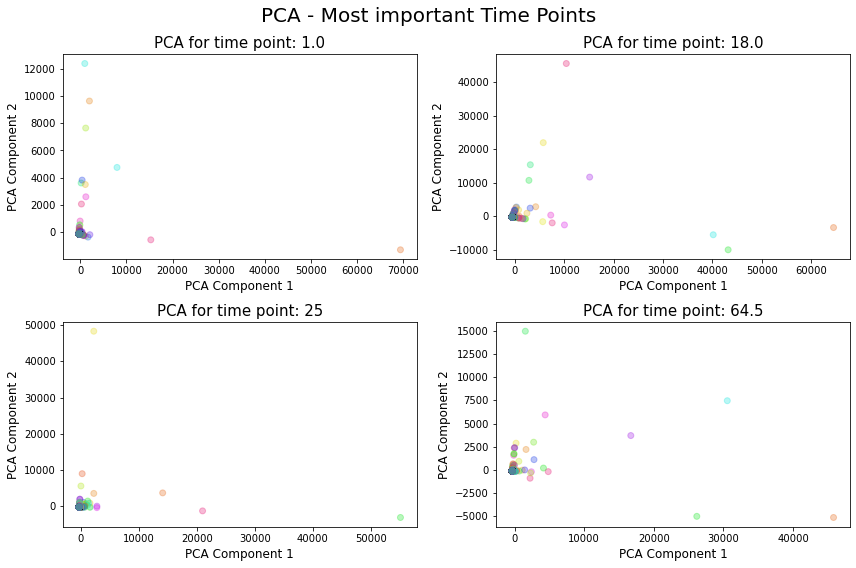

In [33]:
plot_dim_reduc(mouse_time_df, time_points, "PCA", "Most important Time Points")

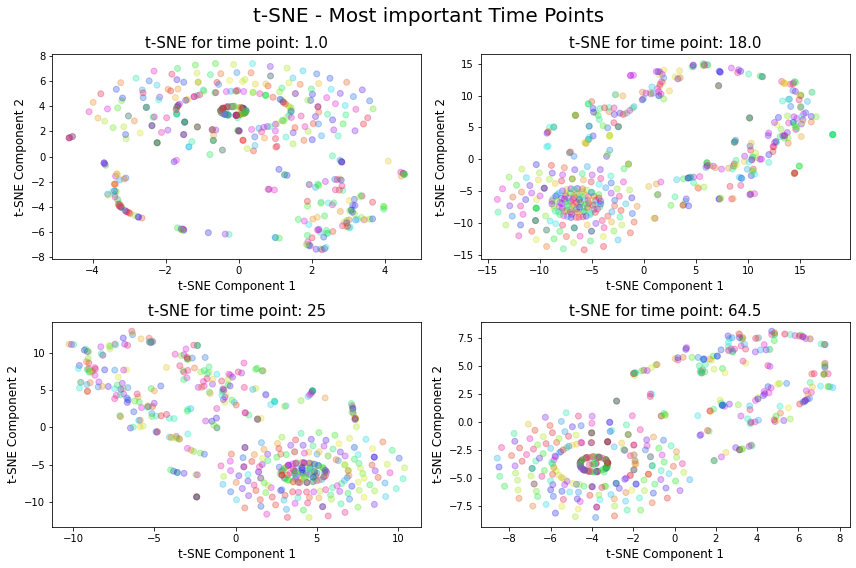

In [65]:
plot_dim_reduc(mouse_time_df, time_points, "t-SNE", "Most important Time Points")

## TODO: Format df into usable df for modeling
- Perhaps try to select from the second "timepoint" index the timepoints we want for each mouse
- And then set that index as column
- And then use 1 hot enocding function to match the unique timepoints (like 3.5, 10.0) to 1 hot encoded values

In [67]:
mouse_time_df

ASV                ASV_1    ASV_2    ASV_3     ASV_4    ASV_5     ASV_6  \
mouse timepoint                                                           
2     0.0         1099.0    180.0     10.0     3.000    6.000     0.001   
      0.5         3299.0    826.0      7.0     0.001   13.000     0.001   
      1.0         1742.0   1338.0     10.0     9.000  194.000     2.000   
      1.5          195.0   4577.0     23.0    32.000  514.000     7.000   
      2.0          476.0   9958.0    104.0   205.000  738.000    71.000   
...                  ...      ...      ...       ...      ...       ...   
10    61.0       13600.0   8525.0   6678.0    34.000    0.001  3567.000   
      62.0       12213.0   9318.0   7735.0    44.000    0.001  5635.000   
      63.0       14885.0   3360.0   2621.0  3573.000    0.001  6371.000   
      64.0       15713.0   8283.0  10539.0    38.000    0.001  4086.000   
      64.5       33332.0  15204.0  19400.0    60.000    0.001  9964.000   

ASV               ASV_7   ASV_8     ASV_9  ASV_10  ...  ASV_569  ASV_574  \
mouse timepoint                                    ...                     
2     0.0          67.0    44.0   178.000   206.0  ...    0.001    0.001   
      0.5         173.0    49.0   726.000   155.0  ...    0.001    0.001   
      1.0         814.0   711.0     0.001  3990.0  ...    0.001    0.001   
      1.5        2375.0  2686.0    20.000  8231.0  ...    0.001    0.001   
      2.0        5608.0  8250.0    48.000  3503.0  ...    0.001    0.001   
...                 ...     ...       ...     ...  ...      ...      ...   
10    61.0        332.0  1903.0   713.000   183.0  ...    0.001    0.001   
      62.0        365.0  1995.0  1636.000   186.0  ...    0.001    0.001   
      63.0       1543.0   615.0   637.000   656.0  ...    0.001    0.001   
      64.0        275.0  1766.0  1039.000   451.0  ...    0.001    0.001   
      64.5        577.0  3406.0  2772.000  1101.0  ...    0.001    0.001   

ASV              ASV_575  ASV_578  ASV_580  ASV_581  ASV_582  ASV_586  \
mouse timepoint                                                         
2     0.0          0.001    0.001    0.001    0.001    0.001    0.001   
      0.5          0.001    0.001    0.001    0.001    0.001    0.001   
      1.0          0.001    0.001    0.001    0.001    0.001    0.001   
      1.5          0.001    0.001    0.001    0.001    0.001    0.001   
      2.0          0.001    0.001    0.001    0.001    0.001    0.001   
...                  ...      ...      ...      ...      ...      ...   
10    61.0         0.001    0.001    0.001    0.001    0.001    0.001   
      62.0         0.001    0.001    0.001    0.001    0.001    0.001   
      63.0         0.001    0.001    0.001    0.001    0.001    0.001   
      64.0         0.001    0.001    0.001    0.001    0.001    0.001   
      64.5         0.001    0.001    0.001    0.001    0.001    0.001   

ASV              ASV_589  ASV_592  
mouse timepoint                    
2     0.0          0.001    0.001  
      0.5          0.001    0.001  
      1.0          0.001    0.001  
      1.5          0.001    0.001  
      2.0          0.001    0.001  
...                  ...      ...  
10    61.0         0.001    0.001  
      62.0         0.001    0.001  
      63.0         0.001    0.001  
      64.0         0.001    0.001  
      64.5         0.001    0.001  

[686 rows x 488 columns]

## This is some code I created for the CS109A project to 1 hot encode variables
- Perhaps you can use it as well

In [ ]:
# Custom one hot encoding function for non numerical columns/features
def one_hot_encode(df_one_hot, cols, drop_orig = False, force_lc = False, output_stats = True):
    encoded_cols_added = 0
    amount_cols_before = len(df_one_hot.columns)
    
    for col in cols:
        dummies = pd.get_dummies(df_one_hot[col], prefix=col)
        print(f"Predictor '{col}' has {len(dummies.columns)} categories added")
        df_one_hot = pd.concat([df_one_hot, dummies], axis=1)
        encoded_cols_added += len(dummies.columns)
    
    # Drop original columns
    if drop_orig:
        df_one_hot = df_one_hot.drop(cols, axis=1)
    
    # Output changes made
    if output_stats:
        print(f"Dropped original -> {drop_orig}")
        print(f"Added {encoded_cols_added} one hot encoded cols.")
        print(f"Started with {amount_cols_before} to a total of {len(df_one_hot.columns)} columns")
    
    # Lowercase all columns if required
    if force_lc:
        df_one_hot.columns= df_one_hot.columns.str.lower()
    
    return df_one_hot



In [ ]:
# Categorical variables to process
cat_vars = ['manner_of_death','armed', 'gender', 'state',
            'threat_level','flee', 'body_camera', 'race']

# cat_columns = df2[['manner_of_death','armed', 'gender', 'state', 'threat_level','flee',
#                    'body_camera', 'is_geocoding_exact', 'year', 'race']]

# Enocde all the data
df5 = one_hot_encode(df4, cat_vars, drop_orig = True, force_lc = True)

# Validate data mutation and output the rest
display(df5.head())

## Logistic Regression Baseline Model


In [94]:
df_model = mouse_time_df.copy()

In [97]:
meta_df.time.unique()

array([ 0. , 10. , 11. , 14. , 16. , 18. ,  1. ,  1.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 25. , 29. , 29.5,  2. ,  2.5, 30. , 30.5,
       31. , 31.5, 32. , 33. , 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. ,
       39. ,  3. ,  3.5, 42. , 42.5, 43. , 43.5, 44. , 44.5, 45. , 45.5,
       46. , 47. ,  4. ,  4.5,  5. , 50. , 50.5, 51. , 51.5, 52. , 52.5,
       53. , 54. , 57. , 57.5, 58. , 58.5, 59. , 59.5,  6. , 60. , 60.5,
       61. , 62. , 63. , 64. , 64.5,  7. ,  8. ,  9. ,  0.5, 28. , 28.5])

In [125]:
df_model_time10 = df_model.xs(10.0, level=1, drop_level=True)
df_model_time16 = df_model.xs(16.0, level=1, drop_level=True)
df_model_time21 = df_model.xs(21.0, level=1, drop_level=True)
df_model_time25 = df_model.xs(25.0, level=1, drop_level=True)
df_model_time30 = df_model.xs(30.0, level=1, drop_level=True)
df_model_time35 = df_model.xs(35.0, level=1, drop_level=True)
df_model_time42 = df_model.xs(42.0, level=1, drop_level=True)
df_model_time45 = df_model.xs(45.0, level=1, drop_level=True)
df_model_time50 = df_model.xs(50.0, level=1, drop_level=True)
df_model_time54 = df_model.xs(54.0, level=1, drop_level=True)
df_model_time60 = df_model.xs(60.0, level=1, drop_level=True)

In [126]:
#remove index
df_model_time10 = df_model_time10.reset_index()
df_model_time16 = df_model_time16.reset_index()
df_model_time21 = df_model_time21.reset_index()
df_model_time25 = df_model_time25.reset_index()
df_model_time30 = df_model_time30.reset_index()
df_model_time35 = df_model_time35.reset_index()
df_model_time42 = df_model_time42.reset_index()
df_model_time45 = df_model_time45.reset_index()
df_model_time50 = df_model_time50.reset_index()
df_model_time54 = df_model_time54.reset_index()
df_model_time60 = df_model_time60.reset_index()


In [127]:
df_model_time10['time10'] = 1
df_model_time16['time16'] = 1
df_model_time21['time21'] = 1
df_model_time25['time25'] = 1
df_model_time30['time30'] = 1
df_model_time35['time35'] = 1
df_model_time42['time42'] = 1
df_model_time45['time45'] = 1
df_model_time50['time50'] = 1
df_model_time54['time54'] = 1
df_model_time60['time60'] = 1


In [128]:
df_model_time10

ASV,mouse,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,...,ASV_574,ASV_575,ASV_578,ASV_580,ASV_581,ASV_582,ASV_586,ASV_589,ASV_592,time10
0,2,1112.0,135.0,88.000,3793.000,8074.000,5852.0,106.0,17121.0,35.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1
1,3,5731.0,3245.0,0.001,869.000,5306.000,1339.0,2026.0,6529.0,26.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1
2,4,361.0,171.0,0.001,3377.000,5793.000,2557.0,104.0,8590.0,9.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1
3,5,4524.0,3381.0,253.000,3210.000,10751.000,3539.0,2090.0,4493.0,62.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1
4,6,12832.0,6302.0,12038.000,32.000,63.000,1169.0,1071.0,348.0,2254.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1
5,7,11851.0,8709.0,18428.000,16.000,0.001,1990.0,1406.0,513.0,2244.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1
6,8,12713.0,7474.0,9647.000,0.001,0.001,2633.0,1088.0,423.0,2112.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1
7,9,11124.0,8162.0,14437.000,0.001,0.001,1612.0,1115.0,573.0,2908.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1
8,10,10503.0,9319.0,9380.000,0.001,0.001,3066.0,1612.0,404.0,2125.0,...,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,0.001,1


In [129]:
df_mice_concat = pd.concat([df_model_time10, df_model_time16, df_model_time21, df_model_time25, df_model_time30, df_model_time35, df_model_time42, df_model_time45, df_model_time50, df_model_time54, df_model_time60], ignore_index=True)

In [130]:
df_mice_concat=df_mice_concat.fillna(0)

In [131]:
df_mice_concat.columns

Index(['mouse', 'ASV_1', 'ASV_2', 'ASV_3', 'ASV_4', 'ASV_5', 'ASV_6', 'ASV_7',
       'ASV_8', 'ASV_9',
       ...
       'time16', 'time21', 'time25', 'time30', 'time35', 'time42', 'time45',
       'time50', 'time54', 'time60'],
      dtype='object', name='ASV', length=500)

In [132]:
df_mice_concat.tail()

ASV,mouse,ASV_1,ASV_2,ASV_3,ASV_4,ASV_5,ASV_6,ASV_7,ASV_8,ASV_9,...,time16,time21,time25,time30,time35,time42,time45,time50,time54,time60
94,6,34993.0,1299.0,2.0,61.0,0.001,244.0,209.0,19.0,471.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
95,7,12159.0,6457.0,3715.0,59.0,0.001,1576.0,999.0,121.0,195.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
96,8,13157.0,15330.0,3837.0,38.0,0.001,7564.0,2643.0,240.0,354.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
97,9,23613.0,10875.0,21.0,22.0,15.000,3496.0,1903.0,56.0,1821.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
98,10,20378.0,9705.0,232.0,51.0,0.001,7821.0,338.0,1994.0,1342.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [133]:
# create y-binary class for healthy & non-healthy mice
df_mice_concat['y_binary'] = df_mice_concat['mouse'].apply(lambda x: 1 if x >= 6 else 0)


In [134]:
np.random.seed(123)

train, test, = train_test_split(df_mice_concat, test_size=0.2,  random_state = 123, shuffle=True)

In [136]:
predictors = ['ASV_1', 'ASV_2', 'ASV_3', 'ASV_4', 'ASV_5', 'time10','time16', 'time21','time25','time30','time35','time42','time45','time50','time54','time60']

# select variables for model estimation
X_train = train[predictors]
y_train = train['y_binary']

X_test = test[predictors]
y_test = test['y_binary']

# define the model
logit_baseline = LogisticRegression(penalty='none',max_iter=500)

#Fit the model using the training set
logit_baseline.fit(X_train , y_train)

# Get the coefficient estimates for the  intercept
B0 = np.around(logit_baseline.intercept_[0], decimals=4)

# Get the coefficient estimates for the  predictors
B1 = np.around(logit_baseline.coef_[0][0], decimals=4)
B2 = np.around(logit_baseline.coef_[0][1], decimals=4)
B3 = np.around(logit_baseline.coef_[0][2], decimals=4)
B4 = np.around(logit_baseline.coef_[0][3], decimals=4)
B5 = np.around(logit_baseline.coef_[0][4], decimals=4)

print(f'Coefficient estimates for the binary predictors in this model:\n')
print(f'The estimated Logistic Regression Coefficient beta 0 for the incercept is: {B0}')
print(f'The estimated Logistic Regression Coefficient beta 1 for predictor 1 is: {B1}')
print(f'The estimated Logistic Regression Coefficient beta 2 for predictor 2 is: {B2}')
print(f'The estimated Logistic Regression Coefficient beta 3 for predictor 3 is: {B3}')
print(f'The estimated Logistic Regression Coefficient beta 4 for predictor 4 is: {B4}')
print(f'The estimated Logistic Regression Coefficient beta 5 for predictor 5 is: {B5}')
print('\n')

Coefficient estimates for the binary predictors in this model:

The estimated Logistic Regression Coefficient beta 0 for the incercept is: -0.0
The estimated Logistic Regression Coefficient beta 1 for predictor 1 is: 0.0011
The estimated Logistic Regression Coefficient beta 2 for predictor 2 is: 0.0018
The estimated Logistic Regression Coefficient beta 3 for predictor 3 is: 0.0008
The estimated Logistic Regression Coefficient beta 4 for predictor 4 is: -0.0111
The estimated Logistic Regression Coefficient beta 5 for predictor 5 is: -0.004




In [137]:
# Calculate accuracy for training and test

# Predictions from train sample
y_pred_train = logit_baseline.predict(X_train)
    
# Predictions from test sample
y_pred_test = logit_baseline.predict(X_test)    

# Calculate accuracy for training and test
logit_train_accuracy = accuracy_score(y_train, y_pred_train)
logit_test_accuracy = accuracy_score(y_test, y_pred_test)

print('\n')

print(f'The training classification accuracy of the baseline model is: {logit_train_accuracy * 100:.1f} %')
print(f'The test classification accuracy of the baseline model is: {logit_test_accuracy * 100:.1f} %')



The training classification accuracy of the baseline model is: 100.0 %
The test classification accuracy of the baseline model is: 100.0 %


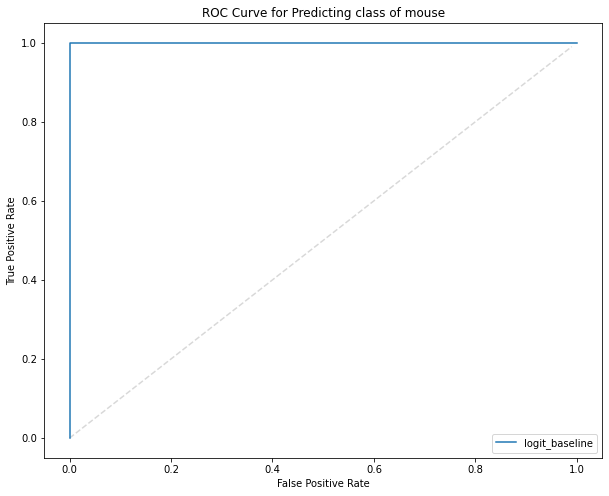

In [139]:
yhat_logit_baseline= logit_baseline.predict_proba(X_test)[:,1]
#yhat_logit_lasso= logit_lasso.predict_proba(X_test_df)[:,1]
#yhat_logit_lasso_interact= logit_lasso_interact.predict_proba(X_test_interact_df)[:,1]

fpr_logit_baseline, tpr_logit_baseline, thresholds_logit_baseline = metrics.roc_curve(y_test, yhat_logit_baseline)
#fpr_logit_lasso, tpr_logit_lasso, thresholds_logit_lasso = metrics.roc_curve(y_test, yhat_logit_lasso)
#fpr_logit_lasso_interact, tpr_logit_lasso_interact, thresholds_logit_lasso_interact = metrics.roc_curve(y_test, yhat_logit_lasso_interact)

fig = plt.figure(figsize=(10, 8))
x=np.arange(0,100)/100
plt.plot(x,x,'--',color="gray",alpha=0.3)
plt.plot(fpr_logit_baseline,tpr_logit_baseline,label="logit_baseline")
#plt.plot(fpr_logit_lasso,tpr_logit_lasso,label="logit_lasso")
#plt.plot(fpr_logit_lasso_interact,tpr_logit_lasso_interact,label="logit_lasso_interact")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.title("ROC Curve for Predicting class of mouse")
plt.legend()
plt.show()

In [140]:
# Calculate confusion matrix

preds = pd.DataFrame(data=yhat_logit_baseline)
preds = preds[0].apply(lambda x: 1 if x > 0.5 else 0)


In [142]:
cf_matrix = confusion_matrix(y_test, preds) 

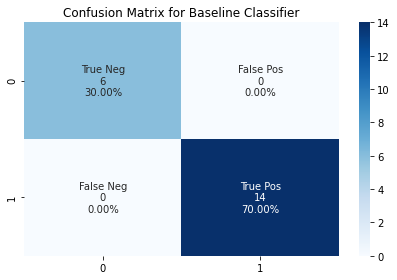

In [143]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
plt.title("Confusion Matrix for Baseline Classifier")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.tight_layout()